In [2]:
import sys
import warnings
from config import *

sys.path.append(f"{ROOT}")

warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import time
import pickle
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from ss_inference.data import SecondaryStructureRawDataset, collate_sequences
from ss_inference.model import NetSurfP2, ConvNet

from utils import *
from pattern_matching.data_extraction import from_fasta_to_df, from_df_to_fasta
from pattern_matching.pattern import PatternMatching, Matching

from config import DATA
from pgm.data import SequenceData, SequenceStructureData
from pgm.layers import GaussianLayer, OneHotLayer, DReLULayer
from pgm.edge import Edge
from pgm.model import MRF
from pgm.utils import *

torch.cuda.is_available()

ValueError: attempted relative import beyond top-level package

In [4]:
DATASET = "PF07736"

batch_size = 300

all_files = ['natural',
 'ind_rejection_sampling_T_0.05',
 'ind_rejection_sampling_T_1',
 'ind_rejection_sampling_T_10000',
 'rbm_rejection_sampling_T_0.05',
 'rbm_rejection_sampling_T_1',
 'rbm_rejection_sampling_T_10000']

## Data

In [5]:
dataset = SequenceData(f"{DATA}/{DATASET}", dataset="full")
loader = DataLoader(dataset, batch_size = 100, 
                          shuffle = False)

In [6]:
device = torch.device('cuda')

model_ss3 = NetSurfP2(50, "netsurfp2")
model_ss3.load_state_dict(torch.load(f"{DATA}/secondary_structure/lstm_50feats.h5"))
model_ss3 = model_ss3.to(device)

model_ss3

Model netsurfp2-50

In [179]:
seq_hmm = torch.tensor(dataset[0][3]).t()[20:]
torch.save(seq_hmm, f"{DATA}/{DATASET}/hmm.pt")
_, size = seq_hmm.size()

In [187]:
n_patterns, c_patterns, _ =  pickle.load(open(f"{DATA}/{DATASET}/patterns.pkl","rb"))
regexes = []
for x in n_patterns:
    if len(x):
        regexes.append([(i,None,None) for i in x])
size = 150
Q = np.ones((3, size+1, size+1)) * (-np.inf)
e = size
for i in range(size+1):
    Q[:3, i, i+1:] = 0
Q = Q.reshape(1, *Q.shape)

ss_hmm = pickle.load(open(f"{DATA}/{DATASET}/ss_profile.pkl", "rb"))
seq_hmm = torch.load(f"{DATA}/{DATASET}/hmm.pt")

matcher = PatternMatching(model_ss3, pattern = regexes[1], Q = Q ,
                          seq_hmm = seq_hmm, ss_hmm = ss_hmm, 
                          size = size, name = c_patterns[1])

In [188]:
len_pat = len(matcher.pattern)
ll_, t_, ls_, m_, p_ = [],[],[],[],[]

for filename in all_files:
    ll, p, t, ls, m = [],[],[],[],[]
    x = torch.load(f"{DATA}/{DATASET}/gen_data/{filename}.pt")
    for i in tqdm(range(len(x)//batch_size + 1)):
        m = Matching(x[batch_size*i:batch_size*(i+1)])
        matcher(m)
        ll +=[x[:, :n] for x, n in zip(m.ll, m.ls)] 
        p += [x[:, :n] for x, n in zip(m.p, m.ls)]
        t += [x for x in m.t]
        ls += [n for n in m.ls]
        m += [m for m in m.M]
    ll_.append(ll)
    t_.append(t)
    ls_.append(ls)
    m_.append(m)
    p_.append(p)

100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


## Analysis

In [240]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer

In [191]:
a = torch.zeros((len(t_), len(t_[0]), len(t_[0][0]), 30))
for k, temp_t_ in enumerate(t_):
    for j in tqdm(range(30)):
        a[k, :, :, j] = trace(torch.exp(temp_t_), offset = j)

100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


In [192]:
u = torch.arange(30).reshape(1,1,1,30)
X = (a*u).sum(-1)

In [169]:
X_n = np.zeros(X.shape)

n_clusters = 5
scalers = [PowerTransformer() for _ in range(n_clusters)]

gm = GaussianMixture(n_clusters)
c = gm.fit_predict(X[0])
scalers = [scaler.fit(X[0, np.array(c==i, dtype=bool)]) for i, scaler in enumerate(scalers)]
for i, x in enumerate(X):
    c = gm.predict(x)
    for j, scaler in enumerate(scalers):
        idx = np.array(c==j, dtype=bool)
        if sum(idx) > 0:
            X_n[i, idx] = scaler.transform(x[idx])

In [258]:
idxs = X[0].std(0)/X[0].mean(0) < np.inf
scaler = RobustScaler()
scaler.fit(X[0])
X_n = np.zeros((*X.shape[:-1], sum(idxs)))
#m, s = mode(X[0]).view(1,-1), X[0].std(0).view(1,-1)
for i in range(len(all_files)):
    X_n[i] = scaler.transform(X[i])
    #X_n[i] = ((X[i]-m)/s)[:,idxs]

In [ ]:
m, M = -5,5
x = np.linspace(m,M,50)
for i, file in enumerate(all_files):
    print(file)
    plt.figure(figsize = (15, 8))
    for j in range(7):
        plt.subplot(2, 4, j+1)
        plt.hist(X_n[i,:,j], bins = x, density=True)
        plt.title(f"beta 1 (m = {X_n[i,:,j].mean():.2f}, std = {X_n[i,:,j].std():.2f})")
        plt.xlim(m,M)
        plt.ylim(0, 1.3)
    
    
    plt.subplot(2, 4, 8)
    plt.hist(X_max[i,:], bins = x, density=True)
    plt.xlim(0,5)
    plt.ylim(0, 1.)
    plt.title(f"worst beta (m = {X_max[i,:].mean():.2f}, std = {X_max[i,:].std():.2f})")

    plt.show()

In [ ]:
stds = np.zeros((len(all_files), 7, 6))
for i, x in enumerate(X_n):
    for j in range(6):
        stds[i, :, j] = (np.abs(x)>=j).mean(0)

for i in range(7):
    plt.figure(figsize=(8,8))
    for s in stds:
        plt.plot(np.log(s[i]+np.exp(-8)))
        plt.ylim(-8, 0)
    plt.legend(all_files)
    plt.show()

### Max divergence

In [260]:
X_max = np.max(np.abs(X_n), 2)
x = np.linspace(0,5,100)
stds_max = np.zeros((len(all_files), len(x)))
for i, y in enumerate(X_max):
    for j, t in enumerate(x):
        stds_max[i, j] = (np.abs(y)>=t).mean()

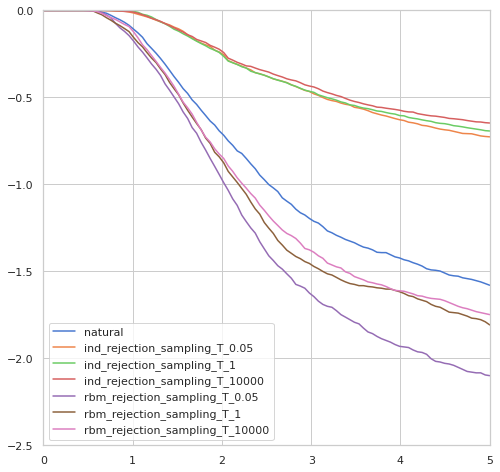

In [263]:
plt.figure(figsize=(8,8))
for s in stds_max:
    plt.plot(x, np.log(s+1e-28))
    plt.xlim(0,5)
    plt.ylim(-2.5, 0)
plt.legend(all_files)
plt.show()

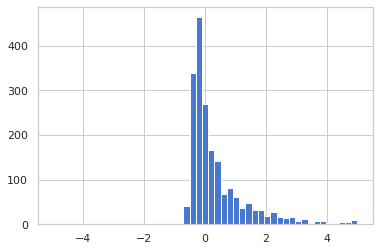

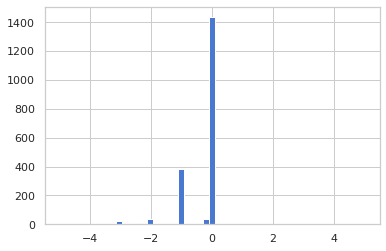

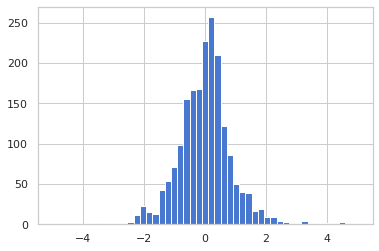

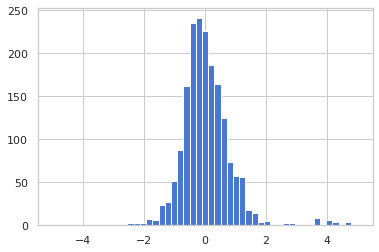

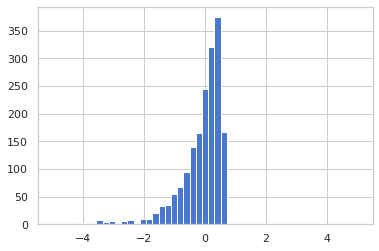

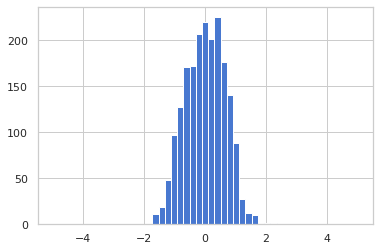

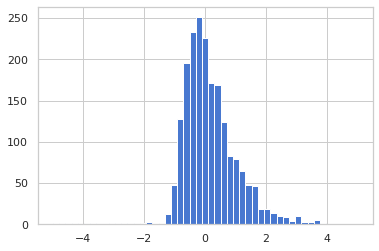

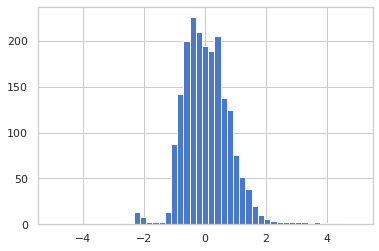

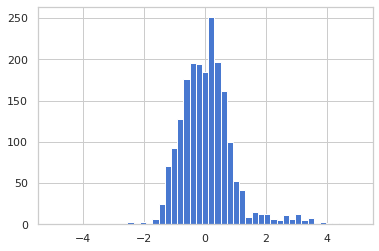

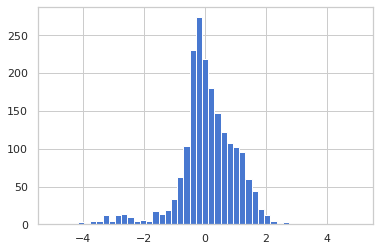

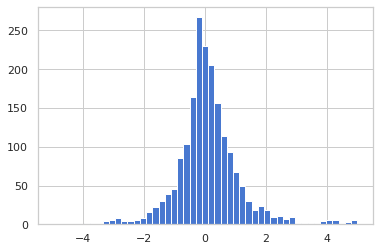

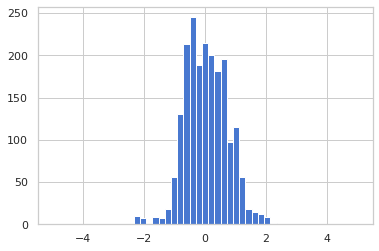

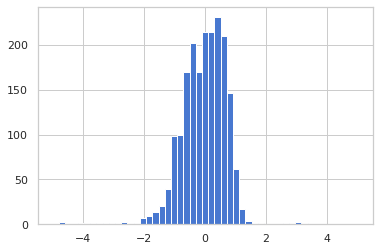

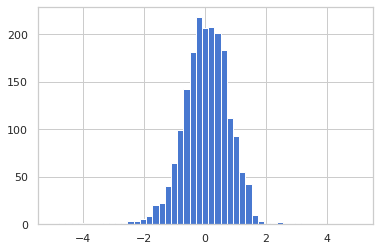

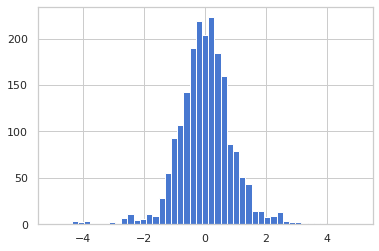

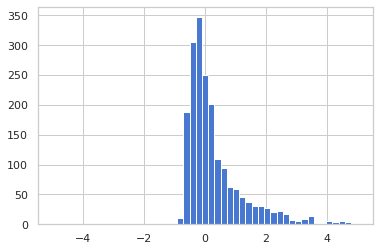

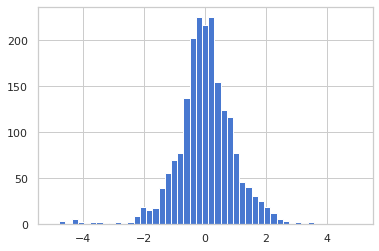

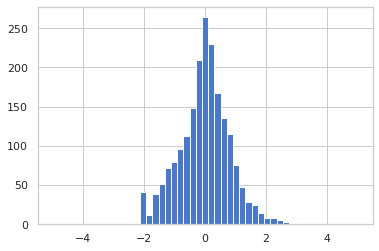

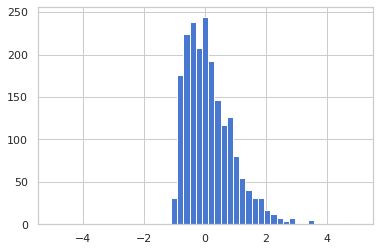

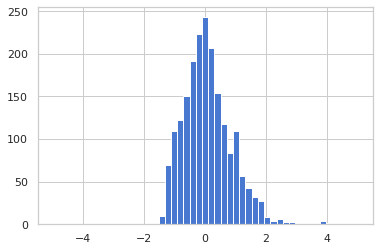

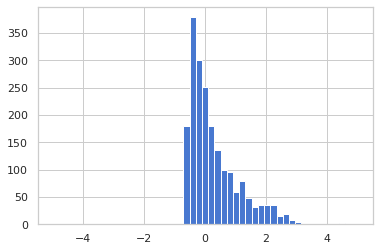

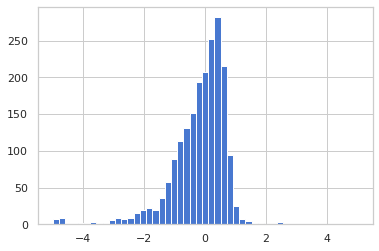

In [262]:
m, M = -5,5
x_ = np.linspace(m,M,50)

for y in X_n[0].T:
    plt.hist(y, bins = x_)

    #for i in range(n_clusters):
    #    plt.subplot(1, n_clusters, i+1)
    #    plt.hist(x[np.array(c==i, dtype=bool)], bins = 30)
    #    plt.title(f"std = {x[np.array(c==i, dtype=bool)].std().item()/x.mean().item():.2f}")
    plt.show()